<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#현재-상태" data-toc-modified-id="현재-상태-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>현재 상태</a></span><ul class="toc-item"><li><span><a href="#Stacking(1)" data-toc-modified-id="Stacking(1)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Stacking(1)</a></span></li><li><span><a href="#Stacking(2)" data-toc-modified-id="Stacking(2)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Stacking(2)</a></span></li><li><span><a href="#현재상태-+-C유형만-따로-Prophet으로-예측" data-toc-modified-id="현재상태-+-C유형만-따로-Prophet으로-예측-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>현재상태 + C유형만 따로 Prophet으로 예측</a></span></li><li><span><a href="#Stacking(3)-+-C-유형은-Prophet으로" data-toc-modified-id="Stacking(3)-+-C-유형은-Prophet으로-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Stacking(3) + C 유형은 Prophet으로</a></span></li><li><span><a href="#현재상태의-Feature들을-가지고-Y값과의-EDA-수행하는-것부터-다시-하자!" data-toc-modified-id="현재상태의-Feature들을-가지고-Y값과의-EDA-수행하는-것부터-다시-하자!-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>현재상태의 Feature들을 가지고 Y값과의 EDA 수행하는 것부터 다시 하자!</a></span></li><li><span><a href="#Stacking(4)" data-toc-modified-id="Stacking(4)-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Stacking(4)</a></span></li><li><span><a href="#자기상관-변수-더-만들기" data-toc-modified-id="자기상관-변수-더-만들기-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>자기상관 변수 더 만들기</a></span></li><li><span><a href="#하이퍼파라미터-튜닝" data-toc-modified-id="하이퍼파라미터-튜닝-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>하이퍼파라미터 튜닝</a></span></li></ul></li></ul></div>

In [3]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pymysql
import warnings
warnings.filterwarnings(action='ignore')


def load_datasets(path) -> pd.DataFrame:
    train = pd.read_csv(os.path.join(path, '한국가스공사_시간별 공급량_20181231.csv'),
                        encoding='cp949')
    test = pd.read_csv(os.path.join(path, 'test.csv'))
    # test 데이터 전처리
    test['연월일'] = test['일자|시간|구분'].str.split(' ', expand=True)[0]
    test['시간'] = test['일자|시간|구분'].str.split(' ', expand=True)[1].astype(int)
    test['구분'] = test['일자|시간|구분'].str.split(' ', expand=True)[2]
    del test['일자|시간|구분']

    data = pd.concat([train, test], axis=0)
    data['연월일'] = pd.to_datetime(data['연월일'])
    return data

def load_weather() -> pd.DataFrame:
    db = pymysql.connect(host='localhost', port=3306, user='younghun', password='watson1259',
                        db='dacon_gas_weather_db', charset='utf8')
    cursor = db.cursor()
    sql = "SELECT datetime, avg_temp, min_temp, max_temp,\
              NULLIF(sum_rain, '') as sum_rain, avg_wind, avg_humid,\
              sum_gsr, NULLIF(ddmefs, '') as ddmefs, avg_ts \
              FROM weather ORDER BY datetime"
    
    weather = pd.read_sql(sql, db)
    weather = weather.fillna(0.)
    
    return weather
    
def merge_gas_weather(path):
    gas = load_datasets(path)
    weather = load_weather()
    gas_weather = gas.merge(weather, how='left', left_on='연월일', right_on='datetime')
    del gas_weather['datetime']
    
    return gas_weather

def make_datetime_vars(data) -> pd.DataFrame:
    data['year'] = data['연월일'].dt.year
    data['month'] = data['연월일'].dt.month
    data['day'] = data['연월일'].dt.day
    data['week_no'] = data['연월일'].dt.strftime("%V").astype(int)
    data['dayofweek'] = data['연월일'].dt.dayofweek
    data['weekend_yn'] = np.where(data['dayofweek'].isin(['Saturday', 'Sunday']), 1, 0)
    data['dayofyear'] = data['연월일'].dt.dayofyear

    return data


def change_dates(row):
    if row['시간'] == 24:
        row['연월일'] += pd.DateOffset(days=1)
        row['시간'] = 0
    return row


def change_pandas_date_format(df):
    """ 연월일 날짜 포맷 바꾸기"""
    df = df.apply(change_dates, axis=1)
    df['시간'] = df['시간'].apply(lambda x: str(x) if x >= 10 else '0' + str(x))
    df['연월일'] = df['연월일'].astype(str)
    df['datetime'] = df['연월일'] + ' ' + df['시간']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H')

    df['prev_datetime'] = df['datetime'] - pd.DateOffset(years=1)

    return df


def make_autocorr_vars(df, gubun='A'):
    sub_df = df[df['구분'] == gubun]
    # 일년 전 그 시간대 공급량
    sub_df['prev_year_공급량'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
                                          sub_df['datetime'].dt.hour])['공급량'].shift()
#     # 이년 전 공급량 파생변수 생성
#     sub_df['prev_two_year_공급량'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
#                                               sub_df['datetime'].dt.hour])['공급량'].shift(2)
    #===============
    #일년 전 평균 공급량
    #===============
    sub_df['prev_year'] = sub_df['prev_datetime'].dt.year
    prev_year_mean_df = sub_df.groupby([sub_df['datetime'].dt.year])['공급량'].mean()
    prev_year_mean_dict = dict(zip(prev_year_mean_df.index, prev_year_mean_df.values.reshape(-1, )))
    sub_df['prev_year_avg_공급량'] = sub_df['prev_year'].map(prev_year_mean_dict)
    #====================
    # 일년 전 월별 평균 공급량
    #====================
    prev_month_mean_df = sub_df.groupby([sub_df['datetime'].dt.year, sub_df['datetime'].dt.month])['공급량'].mean()
    prev_month_mean_dict = dict(zip(prev_month_mean_df.index, prev_month_mean_df.values.reshape(-1, )))
    sub_df['prev_year_month'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                        sub_df['prev_datetime'].dt.month.values.reshape(-1, )))
    sub_df['prev_month_avg_공급량'] = sub_df['prev_year_month'].map(prev_month_mean_dict)
    #=======================
    # 일년 전 월-일자별 평균 공급량
    #=======================
    prev_month_day_mean_df = sub_df.groupby([sub_df['datetime'].dt.year,
                                           sub_df['datetime'].dt.month,
                                           sub_df['datetime'].dt.day])['공급량'].mean()
    prev_month_day_mean_dict = dict(zip(prev_month_day_mean_df.index, prev_month_day_mean_df.values.reshape(-1, )))

    sub_df['prev_year_month_day'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                            sub_df['prev_datetime'].dt.month.values.reshape(-1, ),
                                            sub_df['prev_datetime'].dt.day.values.reshape(-1, )))
    sub_df['prev_month_day_avg_공급량'] = sub_df['prev_year_month_day'].map(prev_month_day_mean_dict)
    #========================
    # 일년 전 월-시간 별 평균 공급량
    #========================
    prev_month_hour_mean_df = sub_df.groupby([sub_df['datetime'].dt.year,
                                            sub_df['datetime'].dt.month,
                                            sub_df['datetime'].dt.hour])['공급량'].mean()
    prev_month_hour_mean_dict = dict(zip(prev_month_hour_mean_df.index, prev_month_hour_mean_df.values.reshape(-1, )))

    sub_df['prev_year_month_hour'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                             sub_df['prev_datetime'].dt.month.values.reshape(-1, ),
                                             sub_df['prev_datetime'].dt.hour.values.reshape(-1, )))
    sub_df['prev_month_hour_avg_공급량'] = sub_df['prev_year_month_hour'].map(prev_month_hour_mean_dict)
    #==============
    # 증가율 변수 생성
    #==============
    sub_df['prev_year_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_year_avg_공급량'])/sub_df['prev_year_avg_공급량']
    sub_df['prev_month_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_avg_공급량'])/sub_df['prev_month_avg_공급량']
    sub_df['prev_month_day_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_day_avg_공급량'])/sub_df['prev_month_day_avg_공급량']
    sub_df['prev_month_hour_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_hour_avg_공급량'])/sub_df['prev_month_hour_avg_공급량']
    #========================
    # 일년 전 그 날의 기상 변수 FE
    #========================
    weather_cols = ['avg_temp','min_temp','max_temp','sum_rain','avg_wind','avg_humid','sum_gsr','ddmefs','avg_ts']
    for col in weather_cols:
        sub_df[f'prev_year_{col}'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
                                                  sub_df['datetime'].dt.hour])[col].shift()
        sub_df[f'prev_year_{col}'] = pd.to_numeric(sub_df[f'prev_year_{col}'], downcast="float")
    #================
    # 필요한 칼럼들만 추출
    #================
    used_cols = ['연월일', '시간', '구분', 'datetime',
                 #'year', 'month', 'day', 'week_no','dayofweek','weekend_yn','dayofyear',
                 'prev_year_공급량', 'prev_year_avg_공급량','prev_month_avg_공급량', 'prev_month_day_avg_공급량', 'prev_month_hour_avg_공급량',
                 'prev_year_ratio','prev_month_ratio','prev_month_day_ratio','prev_month_hour_ratio']
    #weather_cols = [f'prev_year_{col}' for col in weather_cols]
    #used_cols += weather_cols + ['공급량']
    used_cols += ['공급량']
    sub_df = sub_df[used_cols]
    
    return sub_df


def fe_autocorr_vars(df):
    final_df = pd.DataFrame()
    gubun_cols = ['A','B','C','D','E','G','H']
    for gubun in tqdm(gubun_cols):
        sub_df = make_autocorr_vars(df, gubun=gubun)
        final_df = pd.concat([final_df, sub_df], axis=0)
    return final_df

def change_dates_adversely(row):
    if row['datetime'].hour == 0:
        row['연월일'] -= pd.DateOffset(days=1)
        row['시간'] = 24
    return row

def change_date_format(df):
    df['연월일'] = pd.to_datetime(df['연월일'])
    df['시간'] = df['시간'].astype(int)
    df = df.apply(change_dates_adversely, axis=1)
    
    del df['datetime']
    
    return df


path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
gas_weather = merge_gas_weather(path)
dataset = make_datetime_vars(gas_weather)
dataset = change_pandas_date_format(dataset)
final_df = fe_autocorr_vars(dataset)
final_df = change_date_format(final_df)
final_df = final_df.reset_index(drop=True)

print(final_df.shape)



100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


(383208, 13)


In [4]:
# 2014년부터 데이터 추출하는데, 매변 01-03월만 사용할지, 전체 사용할지 함수
def extract_dataset(final_df, split=False):
    # 2014-01-01부터 사용
    cond = final_df['연월일'].dt.year >= 2014
    final_df = final_df[cond]
    if split:
        cond0103 = (final_df['연월일'].dt.month >= 1) & (final_df['연월일'].dt.month <= 3)
        final_df = final_df[cond0103]
        return final_df
    else:
        return final_df
    
# 구분 없이 통합 예측 or 구분 유형대로 예측하기 위한 데이터 포맷 형태
def predict_simultaneously(final_df, simultaneously=False):
    if simultaneously:
        # 구분 원-핫 인코딩
        final_df[['B','C','D','E','G','H']] = pd.get_dummies(final_df['구분'], drop_first=True).values
        cols_order = final_df.columns.tolist()
        cols_order.remove('공급량')
        cols_order.insert(len(cols_order), '공급량')
        final_df = final_df[cols_order]
        return final_df
    else:
        return final_df

In [25]:
# 구분 유형별로 predict
def get_NMAE(true, pred):
    mae = np.abs(true-pred)/true
    nmae = round(np.mean(mae), 3)
    return nmae

def predict_each_gubun(final_df, model, submission_csv, simultaneously=True):
    # 통합해서 예측
    if simultaneously:
        final_df = final_df.set_index(['연월일', '시간', '구분'])
        idx_level = final_df.index.get_level_values
        #======================
        # Train, Valid로 성능 검증
        #======================
        train = final_df[(idx_level(0) < '2018-09-01')]
        train = train.fillna(method='ffill')
        valid = final_df[(idx_level(0) >=' 2018-09-01') & (idx_level(0) <= '2018-12-31')]
        # X, y 분할
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # fit
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_nmae = get_NMAE(y_train, train_pred)
        valid_nmae = get_NMAE(y_valid, valid_pred)
        print(f'# 통합 예측 - Train NAME:', round(train_nmae, 3))
        print(f'# 통합 예측 - Valid NMAE:', round(valid_nmae, 3))
        #======================
        # 모두 학습시키고 Test로 예측
        #======================
        train = final_df[(idx_level(0) < '2019-01-01')]
        train = train.fillna(method='ffill')
        test = final_df[(idx_level(0) >= '2019-01-01')]
        # X,y 분할
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_test = test.iloc[:, :-1].fillna(method='ffill').values
        # fit
        model.fit(X_train, y_train)
        # predict
        test_pred = model.predict(X_test)
        submission_csv['공급량'] = test_pred
        return submission_csv
        
    else:
        cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
        total_test_pred = np.array([])
        for col in cols:
            gubun_df = final_df[final_df['구분'] == col]
            gubun_df = gubun_df.set_index(['연월일','시간','구분'])

            idx_level = gubun_df.index.get_level_values
            #======================
            # Train, Valid로 성능 검증
            #======================
            train = gubun_df[(idx_level(0) < '2018-01-01')]
            train = train.fillna(method='ffill')  # 결측치 있으면 안도는 모델용
            valid = gubun_df[(idx_level(0) >= '2018-01-01') & (idx_level(0) <= '2018-03-31')]
            # X, y 분할
            X_train, y_train = train.iloc[:, :-1].values, train['공급량']
            X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
            # fit
            model.fit(X_train, y_train)
            # predict
            train_pred = model.predict(X_train)
            valid_pred = model.predict(X_valid)
            # evaluate
            train_nmae = get_NMAE(y_train, train_pred)
            valid_nmae = get_NMAE(y_valid, valid_pred)
            print(f'# {col} - Train NAME:', round(train_nmae, 3))
            print(f'# {col} - Valid NMAE:', round(valid_nmae, 3))
            print()
            #======================
            # 모두 학습시키고 Test로 예측
            #======================
            train = gubun_df[(idx_level(0) < '2019-01-01')]
            train = train.fillna(method='ffill')
            test = gubun_df[(idx_level(0) >= '2019-01-01')]
            # X,y 분할
            X_train, y_train = train.iloc[:, :-1].values, train['공급량']
            X_test = test.iloc[:, :-1]
            X_test = X_test.fillna(method='ffill')  # 결측치 있으면 안도는 모델용
            X_test = X_test.values
            # fit
            model.fit(X_train, y_train)
            # predict
            test_pred = model.predict(X_test)
            total_test_pred = np.append(total_test_pred, test_pred)

        submission_csv['공급량'] = total_test_pred
        return submission_csv, test

In [21]:
# model
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


# 01-03월만 추출 X
df = extract_dataset(final_df, split=False)
# 구분 분리안하고 동시에 예측
df = predict_simultaneously(df, simultaneously=False)

# submit
submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')
# model
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
voting_reg = VotingRegressor(estimators=[('lgbm', lgbm),
                                        ('xgb', xgb)])

submission_csv, test = predict_each_gubun(final_df=df, model=voting_reg, submission_csv=submission_csv,
                                          simultaneously=False)

[13:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# A - Train NAME: 0.117
# A - Valid NMAE: 0.164

[13:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# B - Train NAME: 0.121
# B - Valid NMAE: 0.194

[13:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# C - Train NAME: 1.622
# C - Valid NMAE: 0.149

[13:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# D - Train NAME: 0.115
# D - Valid NMAE:

In [ ]:
sub_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission/'

# 파일명 -> 01-03월 분리여부_구분유형분리여부_모델종류_trainNMAE_validNMAE.csv
submission_csv.to_csv(sub_path+'0103False_SimulFalse_xgb+lgbm_cols-autocorr_ratio.csv', index=False)

## 현재 상태
- 현재 가장 좋은 성능: 0.12679
- 사용한 데이터: 01-03월만 사용한 것이 아닌 모든 데이터 다 사용
- 구분 유형별로 모델링 했는가?: Yes! 구분 유형별로 모델링 함
- 사용한 변수:
    - 1년 전 자기상관 변수들
    - 1년 전 자기상관 변수들 간의 변화율
- 사용한 모델:
    - XGBoost + LightGBM 하이브리드 Voting
<br><br>
- ~~Stacking 모델 시도~~
- Prophet 시도
- 구분 유형별로 모델 종류 달리해서 시도

### Stacking(1)
- 사용한 변수는 위와 동일(자기상관변수들만 사용)
- Single 모델
    - XGBoost
    - LightGBM
    - Random Forest
- 최종 메타 모델: HybridVoting(XGBoost+LightGBM)
- **구분 유형 없이 통합해서 예측**
- Test 성능 0.138로 이전보다 오버피팅 발생..

In [49]:
# 1. XGBoost로 학습 데이터에 대한 예측값, 테스트 데이터에 대한 예측값 반환

def predict_single_model(final_df, idx_level, model):
    #=============================
    # Train, Validation 나누기
    #=============================
    train_v = final_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
    valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')].fillna(method='ffill')
    # X, y 분할
    X_train_v, y_train_v = train_v.iloc[:, :-1].values, train_v['공급량']
    X_valid_v, y_valid_v = valid_v.iloc[:, :-1].values, valid_v['공급량']
    # fit
    model.fit(X_train_v, y_train_v)
    # predict
    train_pred_v = model.predict(X_train_v)
    valid_pred_v = model.predict(X_valid_v)
    
    #=============================
    # Train, Test로 나누어 학습 및 예측
    #=============================
    train = final_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
    test = final_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
    print('# Train shape:', train.shape, '# Test shape:', test.shape)
    # X, y 분할
    X_train, y_train = train.iloc[:, :-1].values, train['공급량']
    X_test = test.iloc[:, :-1].values
    # fit
    model.fit(X_train, y_train)
    # predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print('### Model:', model)
    print('# Train pred shape:', train_pred.shape, '# Test pred shape:', test_pred.shape)
    print()
    return train_pred_v, valid_pred_v, train_pred, test_pred


def predict_stacking(final_df, meta_model, single_models, submission_csv):
    # Multiindex로 변경
    final_df = final_df.set_index(['연월일', '시간', '구분'])
    idx_level = final_df.index.get_level_values
    # 메타모델 성능 체크하기 위해 y값 따로 떼놓기
    y_train_v = final_df[(idx_level(0) < '2018-09-01')]['공급량'].values
    y_valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')]['공급량'].values
    # 메타모델 최종 성능 학습 및 테스트 하기 위해 y값 따로 떼놓기
    y_train = final_df[(idx_level(0) < '2019-01-01')]['공급량'].values
    y_test = final_df[(idx_level(0) >= '2019-01-01')]['공급량'].values  # 최종 예측할 값들이므로 NaN값들임!
    
    #==================================
    # 메타모델의 학습데이터로 사용될 행렬들 초기화
    #==================================
    # 메타모델 성능 검증용 초기화 행렬
    X_train_v = np.zeros((y_train_v.shape[0], len(single_models)))
    X_valid_v = np.zeros((y_valid_v.shape[0], len(single_models)))
    # 메타모델 최종 학습 및 테스트 초기화 행렬
    X_train = np.zeros((y_train.shape[0], len(single_models)))
    X_test = np.zeros((y_test.shape[0], len(single_models)))
    
    #=======================
    # single model 하나씩 수행
    #=======================
    for i, single_model in enumerate(single_models):
        train_pred_v, valid_pred_v, train_pred, test_pred = predict_single_model(final_df, idx_level, single_model)
        # numpy array concatenate
        X_train_v[:, i] = train_pred_v
        X_valid_v[:, i] = valid_pred_v
        X_train[:, i] = train_pred
        X_test[:, i] = test_pred
    
    #==============================
    # 메타모델로 최종 성능 검증 및 최종 예측
    #==============================
    # 성능 검증
    meta_model.fit(X_train_v, y_train_v)
    TRAIN_V_PRED = meta_model.predict(X_train_v)
    VALID_V_PRED = meta_model.predict(X_valid_v)
    TRAIN_V_NMAE = get_NMAE(y_train_v, TRAIN_V_PRED)
    VALID_V_NMAE = get_NMAE(y_valid_v, VALID_V_PRED)
    print('🔥최종 메타 모델 성능 검증- Train NMAE:', TRAIN_V_NMAE)
    print('🔥최종 메타 모델 성능 검증- Valid NMAE:', VALID_V_NMAE)
    
    # 최종 예측
    meta_model.fit(X_train, y_train)
    FINAL_TEST_PRED = meta_model.predict(X_test)
    
    # 제출 csv 파일에 담기
    submission_csv['공급량'] = FINAL_TEST_PRED
    
#     print('메타모델에 사용될 데이터들')
#     print('X_train_v:', X_train_v.shape, 'X_valid_v:', X_valid_v.shape)
#     print('y_train_v:', y_train_v.shape, 'y_valid_v:', y_valid_v.shape)
#     print()
#     print('X_train:', X_train.shape, 'X_test:', X_test.shape)
#     print('y_train:', y_train.shape, 'y_test:', y_test.shape)
    
    return submission_csv
    

lgbm = LGBMRegressor(n_estimators=100, random_state=42)
#xgb = XGBRegressor(n_estimators=100, random_state=42)
#rf = RandomForestRegressor(random_state=42)

META_MODEL = VotingRegressor([('lgbm', lgbm), ('xgb', xgb)])
single_models = [lgbm]



# Train shape: (306768, 10) # Test shape: (15120, 10)
### Model: LGBMRegressor(random_state=42)
# Train pred shape: (306768,) # Test pred shape: (15120,)

[14:24:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Train shape: (306768, 10) # Test shape: (15120, 10)
[14:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### Model: XGBRegressor(random_state=42)
# Train pred shape: (306768,) # Test pred shape: (15120,)

# Train shape: (306768, 10) # Test shape: (15120, 10)
### Model: RandomForestRegressor(random_state=42)
# Train pred shape: (306768,) # Test pred shape: (15120,)

[14:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
🔥최종 메타 모델 성능 검증- Train NMAE: 0.1
🔥최종 메타 모델 성능 검증- Valid NMAE: 0.191
[14:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederr

In [51]:
sub_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission/'

# 파일명 -> 01-03월 분리여부_구분유형분리여부_모델종류_trainNMAE_validNMAE.csv
submission_csv.to_csv(sub_path+'0103False_SimulFalse_Stacking(xgb+lgbm+rf_meta:voting)_cols-autocorr_ratio.csv', index=False)


---
### Stacking(2)
- 사용한 변수는 위와 동일(자기상관변수들만 사용)
- Single 모델
    - XGBoost
    - LightGBM
    - Random Forest
- 최종 메타 모델: HybridVoting(XGBoost+LightGBM)
- **구분 유형 나누어서 예측**

In [46]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import os

def predict_single_model_gubun(final_df, idx_level, model, gubun):
    #=============================
    # Train, Validation 나누기
    #=============================
    train_v = final_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
    valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')].fillna(method='ffill')
    # X, y 분할
    X_train_v, y_train_v = train_v.iloc[:, :-1].values, train_v['공급량']
    X_valid_v, y_valid_v = valid_v.iloc[:, :-1].values, valid_v['공급량']
    # fit
    model.fit(X_train_v, y_train_v)
    # predict
    train_pred_v = model.predict(X_train_v)
    valid_pred_v = model.predict(X_valid_v)
    
    #=============================
    # Train, Test로 나누어 학습 및 예측
    #=============================
    train = final_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
    test = final_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
    print(f'📌 {gubun}-> # Train shape:', train.shape, '# Test shape:', test.shape)
    # X, y 분할
    X_train, y_train = train.iloc[:, :-1].values, train['공급량']
    X_test = test.iloc[:, :-1].values
    # fit
    model.fit(X_train, y_train)
    # predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print(f'📌 {gubun} -> ### Model:', model)
    print(f'📌 {gubun} -> # Train pred shape:', train_pred.shape, '# Test pred shape:', test_pred.shape)
    print()
    return train_pred_v, valid_pred_v, train_pred, test_pred


def predict_stacking_gubun(final_df, meta_model, single_models, gubun='A'):
    # 인자로 넣어준 구분 유형 데이터프레임
    final_df = final_df[final_df['구분'] == gubun]
    # Multiindex로 변경
    final_df = final_df.set_index(['연월일', '시간', '구분'])
    idx_level = final_df.index.get_level_values
    # 메타모델 성능 체크하기 위해 y값 따로 떼놓기
    y_train_v = final_df[(idx_level(0) < '2018-09-01')]['공급량'].values
    y_valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')]['공급량'].values
    # 메타모델 최종 성능 학습 및 테스트 하기 위해 y값 따로 떼놓기
    y_train = final_df[(idx_level(0) < '2019-01-01')]['공급량'].values
    y_test = final_df[(idx_level(0) >= '2019-01-01')]['공급량'].values  # 최종 예측할 값들이므로 NaN값들임!
    
    #==================================
    # 메타모델의 학습데이터로 사용될 행렬들 초기화
    #==================================
    # 메타모델 성능 검증용 초기화 행렬
    X_train_v = np.zeros((y_train_v.shape[0], len(single_models)))
    X_valid_v = np.zeros((y_valid_v.shape[0], len(single_models)))
    # 메타모델 최종 학습 및 테스트 초기화 행렬
    X_train = np.zeros((y_train.shape[0], len(single_models)))
    X_test = np.zeros((y_test.shape[0], len(single_models)))
    
    #=======================
    # single model 하나씩 수행
    #=======================
    for i, single_model in enumerate(single_models):
        train_pred_v, valid_pred_v, train_pred, test_pred = predict_single_model_gubun(final_df, idx_level, 
                                                                                       single_model, gubun)
        # numpy array concatenate
        X_train_v[:, i] = train_pred_v
        X_valid_v[:, i] = valid_pred_v
        X_train[:, i] = train_pred
        X_test[:, i] = test_pred
    
    #==============================
    # 메타모델로 최종 성능 검증 및 최종 예측
    #==============================
    # 성능 검증
    meta_model.fit(X_train_v, y_train_v)
    TRAIN_V_PRED = meta_model.predict(X_train_v)
    VALID_V_PRED = meta_model.predict(X_valid_v)
    TRAIN_V_NMAE = get_NMAE(y_train_v, TRAIN_V_PRED)
    VALID_V_NMAE = get_NMAE(y_valid_v, VALID_V_PRED)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Train NMAE:', TRAIN_V_NMAE)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Valid NMAE:', VALID_V_NMAE)
    
    # 최종 예측
    meta_model.fit(X_train, y_train)
    FINAL_TEST_PRED = meta_model.predict(X_test)
     
#     print('메타모델에 사용될 데이터들')
#     print('X_train_v:', X_train_v.shape, 'X_valid_v:', X_valid_v.shape)
#     print('y_train_v:', y_train_v.shape, 'y_valid_v:', y_valid_v.shape)
#     print()
#     print('X_train:', X_train.shape, 'X_test:', X_test.shape)
#     print('y_train:', y_train.shape, 'y_test:', y_test.shape)
    print('TEST_LABEL shape:', y_test.shape, 'TEST_PRED shape:', FINAL_TEST_PRED.shape)
    return FINAL_TEST_PRED


def predict_stacking(final_df, submission_csv, meta_model, single_models: list, gubuns: list):
    total_gubun_pred = np.array([])
    # 각 구분 유형 별로 Stacking 모델로 예측
    for gubun in gubuns:
        gubun_test_pred = predict_stacking_gubun(final_df, meta_model, single_models, gubun)
        total_gubun_pred = np.append(total_gubun_pred, gubun_test_pred)
    
    # 제출 파일에 칼럼으로 넣기
    submission_csv['공급량'] = total_gubun_pred
    
    return submission_csv

In [ ]:
single_lgbm = LGBMRegressor(n_estimators=200, random_state=42)
single_xgb = XGBRFRegressor(n_estimators=100, random_state=42)
single_rf = RandomForestRegressor(n_estimators=200, min_samples_split=10)
meta_model = VotingRegressor([('lgbm', single_lgbm), ('xgb', single_xgb), ('rf', single_rf)],
                            n_jobs=-1)
single_models = [single_lgbm, single_xgb, single_rf]

# 01-03월만 추출 X
df = extract_dataset(final_df, split=False)
gubuns = df['구분'].unique()

# 제출 파일 로드
sub_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
submission_csv = pd.read_csv(os.path.join(sub_path, 'sample_submission.csv'))

final_submission_csv = predict_stacking(final_df=df, submission_csv=submission_csv,
                                        meta_model=meta_model, single_models=single_models,
                                        gubuns=gubuns)

In [33]:
csv_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission'
filename = '0103False_SimulFalse_Stacking(lgbm_xgb_rf_meta-voting)_cols-autocorr_ratio.csv'
final_submission_csv.to_csv(os.path.join(csv_path, filename), index=False)

---
### 현재상태 + C유형만 따로 Prophet으로 예측

In [36]:
# model
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


# 01-03월만 추출 X
df = extract_dataset(final_df, split=False)
# 구분 분리안하고 동시에 예측
df = predict_simultaneously(df, simultaneously=False)

# submit
submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')
# model
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
voting_reg = VotingRegressor(estimators=[('lgbm', lgbm),
                                        ('xgb', xgb)])

submission_csv, test = predict_each_gubun(final_df=df, model=voting_reg, submission_csv=submission_csv,
                                          simultaneously=False)

[12:18:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# A - Train NAME: 0.117
# A - Valid NMAE: 0.164

[12:18:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# B - Train NAME: 0.121
# B - Valid NMAE: 0.194

[12:18:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# C - Train NAME: 1.622
# C - Valid NMAE: 0.149

[12:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# D - Train NAME: 0.115
# D - Valid NMAE:

In [42]:
# C유형에 대한 최종예측 값 삭제
submission_csv.loc[submission_csv['일자|시간|구분'].str.contains('C'), '공급량'] = np.nan

- C 유형에 대해서는 Kats 모델 사용

In [152]:
c_df = df[df['구분'] == 'C']

In [153]:
def date_format_pandas(row):
    if row['시간'] == 24:
        row['연월일'] += pd.DateOffset(days=1)
        row['시간'] = 0
    return row

c_df = c_df.apply(date_format_pandas, axis=1)

In [154]:
c_df['시간'] = c_df['시간'].apply(lambda x: str(x) if x >= 10 else '0'+str(x))

In [155]:
c_df['연월일'] = c_df['연월일'].astype(str)
c_df['time'] = c_df['연월일'] + ' ' + c_df['시간']

In [156]:
c_df['time'] = pd.to_datetime(c_df['time'], format='%Y-%m-%d %H')

In [157]:
c_df_kats = c_df[['time', '공급량']]

In [162]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

c_train = c_df_kats[c_df_kats['공급량'].notnull()]
c_test = c_df_kats[c_df_kats['공급량'].isnull()]

# Ts 객체로 변환
c_train_ts = TimeSeriesData(c_train)

# Prophet model
params = ProphetParams(seasonality_mode='additive')
model = ProphetModel(c_train_ts, params)

# fit
model.fit()

# predict
c_test_pred = model.predict(steps=c_test.shape[0], freq='H')

In [163]:
c_test_pred

,time,fcst,fcst_lower,fcst_upper
0,2019-01-01 01:00:00,196.870784,163.844434,227.595775
1,2019-01-01 02:00:00,188.341943,157.101997,221.681504
2,2019-01-01 03:00:00,180.878073,149.262089,212.905692
3,2019-01-01 04:00:00,178.108334,150.219222,211.316099
4,2019-01-01 05:00:00,182.755447,150.585278,216.352259
...,...,...,...,...
2155,2019-03-31 20:00:00,118.725606,75.154668,166.141916
2156,2019-03-31 21:00:00,120.550628,77.043059,163.781934
2157,2019-03-31 22:00:00,117.874770,74.729611,163.380741
2158,2019-03-31 23:00:00,112.624121,70.346437,156.944441


In [169]:
submission_csv['일자'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[0]
submission_csv['시간'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[1]
submission_csv['구분'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[2]
submission_csv['일자'] = pd.to_datetime(submission_csv['일자'])
submission_csv['시간'] = submission_csv['시간'].astype(int)

final_csv = submission_csv[submission_csv['구분'] != 'C']
c_csv = submission_csv[submission_csv['구분'] == 'C']
c_csv['공급량'] = c_test_pred['fcst'].values

final_csv = pd.concat([final_csv, c_csv], axis=0).sort_values(by=['구분','일자','시간'])
final_csv = final_csv.drop(['일자','시간','구분'], axis=1)

In [177]:
final_csv = submission_csv[submission_csv['구분'] != 'C']

In [183]:
c_csv['공급량'] = c_test_pred['fcst'].values

In [189]:
final_csv = pd.concat([final_csv, c_csv], axis=0).sort_values(by=['구분','일자','시간'])

In [193]:
final_csv = final_csv.drop(['일자','시간','구분'], axis=1)

In [196]:
csv_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission'
filename = '0103False_SimulFalse_xgb+lgbm_cols-autocorr_ratio_C_gubun_separated.csv'

final_csv.to_csv(os.path.join(csv_path, filename), index=False)

In [197]:
final_csv.shape

(15120, 2)

---

### Stacking(3) + C 유형은 Prophet으로

In [198]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import os

def predict_single_model_gubun(final_df, idx_level, model, gubun):
    #=============================
    # Train, Validation 나누기
    #=============================
    train_v = final_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
    valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')].fillna(method='ffill')
    # X, y 분할
    X_train_v, y_train_v = train_v.iloc[:, :-1].values, train_v['공급량']
    X_valid_v, y_valid_v = valid_v.iloc[:, :-1].values, valid_v['공급량']
    # fit
    model.fit(X_train_v, y_train_v)
    # predict
    train_pred_v = model.predict(X_train_v)
    valid_pred_v = model.predict(X_valid_v)
    
    #=============================
    # Train, Test로 나누어 학습 및 예측
    #=============================
    train = final_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
    test = final_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
    print(f'📌 {gubun}-> # Train shape:', train.shape, '# Test shape:', test.shape)
    # X, y 분할
    X_train, y_train = train.iloc[:, :-1].values, train['공급량']
    X_test = test.iloc[:, :-1].values
    # fit
    model.fit(X_train, y_train)
    # predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print(f'📌 {gubun} -> ### Model:', model)
    print(f'📌 {gubun} -> # Train pred shape:', train_pred.shape, '# Test pred shape:', test_pred.shape)
    print()
    return train_pred_v, valid_pred_v, train_pred, test_pred


def predict_stacking_gubun(final_df, meta_model, single_models, gubun='A'):
    # 인자로 넣어준 구분 유형 데이터프레임
    final_df = final_df[final_df['구분'] == gubun]
    # Multiindex로 변경
    final_df = final_df.set_index(['연월일', '시간', '구분'])
    idx_level = final_df.index.get_level_values
    # 메타모델 성능 체크하기 위해 y값 따로 떼놓기
    y_train_v = final_df[(idx_level(0) < '2018-09-01')]['공급량'].values
    y_valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')]['공급량'].values
    # 메타모델 최종 성능 학습 및 테스트 하기 위해 y값 따로 떼놓기
    y_train = final_df[(idx_level(0) < '2019-01-01')]['공급량'].values
    y_test = final_df[(idx_level(0) >= '2019-01-01')]['공급량'].values  # 최종 예측할 값들이므로 NaN값들임!
    
    #==================================
    # 메타모델의 학습데이터로 사용될 행렬들 초기화
    #==================================
    # 메타모델 성능 검증용 초기화 행렬
    X_train_v = np.zeros((y_train_v.shape[0], len(single_models)))
    X_valid_v = np.zeros((y_valid_v.shape[0], len(single_models)))
    # 메타모델 최종 학습 및 테스트 초기화 행렬
    X_train = np.zeros((y_train.shape[0], len(single_models)))
    X_test = np.zeros((y_test.shape[0], len(single_models)))
    
    #=======================
    # single model 하나씩 수행
    #=======================
    for i, single_model in enumerate(single_models):
        train_pred_v, valid_pred_v, train_pred, test_pred = predict_single_model_gubun(final_df, idx_level, 
                                                                                       single_model, gubun)
        # numpy array concatenate
        X_train_v[:, i] = train_pred_v
        X_valid_v[:, i] = valid_pred_v
        X_train[:, i] = train_pred
        X_test[:, i] = test_pred
    
    #==============================
    # 메타모델로 최종 성능 검증 및 최종 예측
    #==============================
    # 성능 검증
    meta_model.fit(X_train_v, y_train_v)
    TRAIN_V_PRED = meta_model.predict(X_train_v)
    VALID_V_PRED = meta_model.predict(X_valid_v)
    TRAIN_V_NMAE = get_NMAE(y_train_v, TRAIN_V_PRED)
    VALID_V_NMAE = get_NMAE(y_valid_v, VALID_V_PRED)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Train NMAE:', TRAIN_V_NMAE)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Valid NMAE:', VALID_V_NMAE)
    
    # 최종 예측
    meta_model.fit(X_train, y_train)
    FINAL_TEST_PRED = meta_model.predict(X_test)
     
#     print('메타모델에 사용될 데이터들')
#     print('X_train_v:', X_train_v.shape, 'X_valid_v:', X_valid_v.shape)
#     print('y_train_v:', y_train_v.shape, 'y_valid_v:', y_valid_v.shape)
#     print()
#     print('X_train:', X_train.shape, 'X_test:', X_test.shape)
#     print('y_train:', y_train.shape, 'y_test:', y_test.shape)
    print('TEST_LABEL shape:', y_test.shape, 'TEST_PRED shape:', FINAL_TEST_PRED.shape)
    return FINAL_TEST_PRED


def predict_stacking(final_df, submission_csv, meta_model, single_models: list, gubuns: list):
    total_gubun_pred = np.array([])
    # 각 구분 유형 별로 Stacking 모델로 예측
    for gubun in gubuns:
        gubun_test_pred = predict_stacking_gubun(final_df, meta_model, single_models, gubun)
        total_gubun_pred = np.append(total_gubun_pred, gubun_test_pred)
    
    # 제출 파일에 칼럼으로 넣기
    submission_csv['공급량'] = total_gubun_pred
    
    return submission_csv

single_lgbm = LGBMRegressor(n_estimators=200, random_state=42, min_child_samples=40)
single_xgb = XGBRFRegressor(n_estimators=100, random_state=42)
single_rf = RandomForestRegressor(n_estimators=200, min_samples_split=20)
meta_model = VotingRegressor([('lgbm', single_lgbm), ('xgb', single_xgb), ('rf', single_rf)],
                            n_jobs=-1)
single_models = [single_lgbm, single_xgb, single_rf]

# 01-03월만 추출 X
df = extract_dataset(final_df, split=False)
gubuns = df['구분'].unique()

# 제출 파일 로드
sub_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
submission_csv = pd.read_csv(os.path.join(sub_path, 'sample_submission.csv'))

final_submission_csv = predict_stacking(final_df=df, submission_csv=submission_csv,
                                        meta_model=meta_model, single_models=single_models,
                                        gubuns=gubuns)

📌 A-> # Train shape: (43824, 10) # Test shape: (2160, 10)
📌 A -> ### Model: LGBMRegressor(min_child_samples=40, n_estimators=200, random_state=42)
📌 A -> # Train pred shape: (43824,) # Test pred shape: (2160,)

[13:24:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
📌 A-> # Train shape: (43824, 10) # Test shape: (2160, 10)
[13:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
📌 A -> ### Model: XGBRFRegressor(random_state=42)
📌 A -> # Train pred shape: (43824,) # Test pred shape: (2160,)

📌 A-> # Train shape: (43824, 10) # Test shape: (2160, 10)
📌 A -> ### Model: RandomForestRegressor(min_samples_split=20, n_estimators=200)
📌 A -> # Train pred shape: (43824,) # Test pred shape: (2160,)

📌 A -> 🔥최종 메타 모델 성능 검증- Train NMAE: 0.071
📌 A -> 🔥최종 메타 모델 성능 검증- Valid NMAE: 0.175
TEST_LABEL shape: (2160,) TEST_PRED shape: (2160,)
📌 B-> # Train shape: (43824, 10) # Test shape: (

In [200]:
submission_csv = final_submission_csv.copy()

In [203]:
# c_test_pred # <- C유형 Prophet으로 예측한 값들어있음

submission_csv['일자'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[0]
submission_csv['시간'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[1]
submission_csv['구분'] = submission_csv['일자|시간|구분'].str.split(' ', expand=True)[2]
submission_csv['일자'] = pd.to_datetime(submission_csv['일자'])
submission_csv['시간'] = submission_csv['시간'].astype(int)

final_csv = submission_csv[submission_csv['구분'] != 'C']
c_csv = submission_csv[submission_csv['구분'] == 'C']
c_csv['공급량'] = c_test_pred['fcst'].values

final_csv = pd.concat([final_csv, c_csv], axis=0).sort_values(by=['구분','일자','시간'])
final_csv = final_csv.drop(['일자','시간','구분'], axis=1)

In [205]:
csv_path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission'
filename = '0103False_SimulFalse_Stacking(xgb+lgbm+rf-meta:Voting)_cols-autocorr_ratio_C_gubun_separated_Prophet.csv'

final_csv.to_csv(os.path.join(csv_path, filename), index=False)

- Stacking이 더 성능이 오르진 않네...

In [ ]:
### 다시 자기상관 변수 FE으로 돌아가기 + 구분 유형 별로 따로 모델 만들기
# - 1. 구분 유형 별로 일변량 Prophet 돌려서 성능 체크해보기
# - 2. 자기상관 변수 FE 추가 후 XGB+LGBM VotingRegressor(현재 가장 성능 좋은 모델) -> 예측성능 체크
# - 3. 구분 유형 별로 다변량 Prophet 돌려서 성능 체크
# - 만약, Prophet이 더 성능이 좋다면 Prophet에서 파라미터 튜닝..?
# - 만약, 2번의 성능이 여전히 가장 좋다면 Prophet 버리고 머신러닝 모델의 다양화..(Stacking은 너무 오버피팅 되는듯..)

---
### 현재상태의 Feature들을 가지고 Y값과의 EDA 수행하는 것부터 다시 하자!


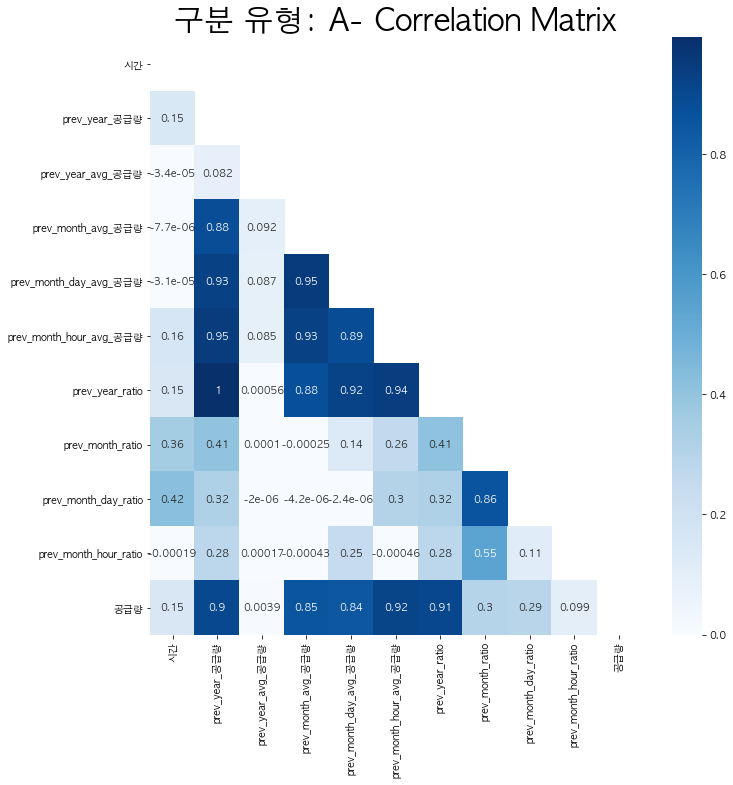

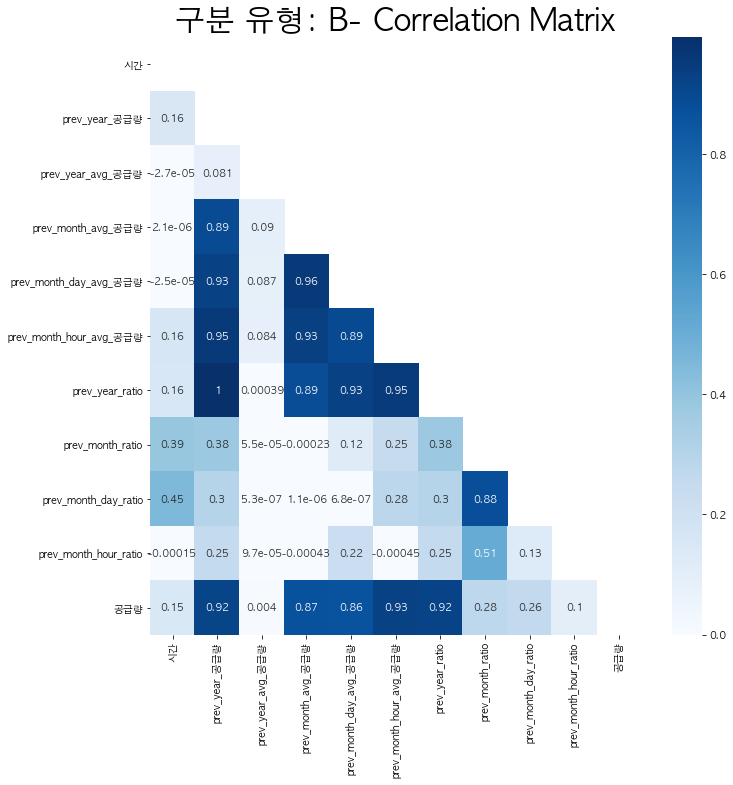

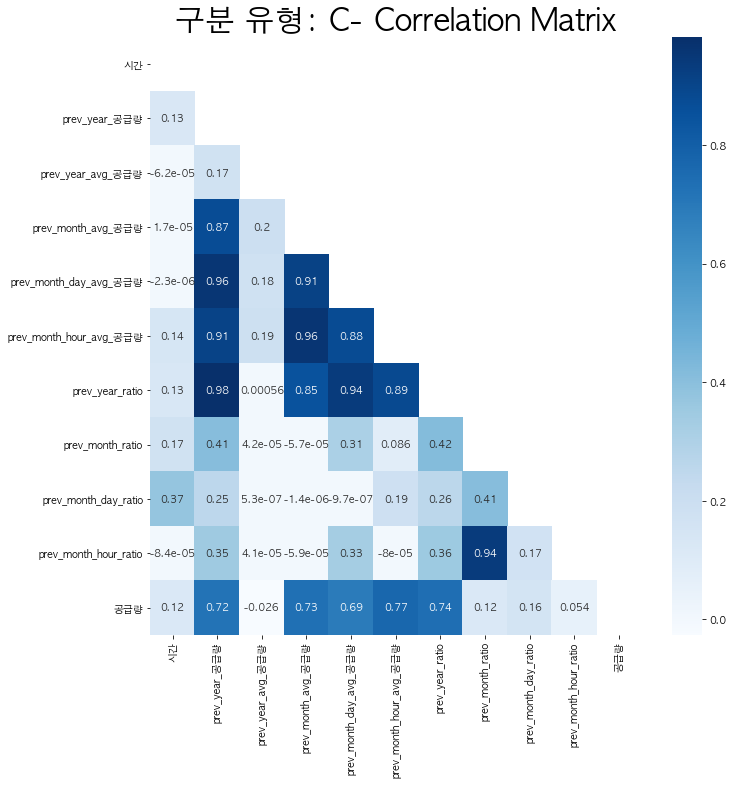

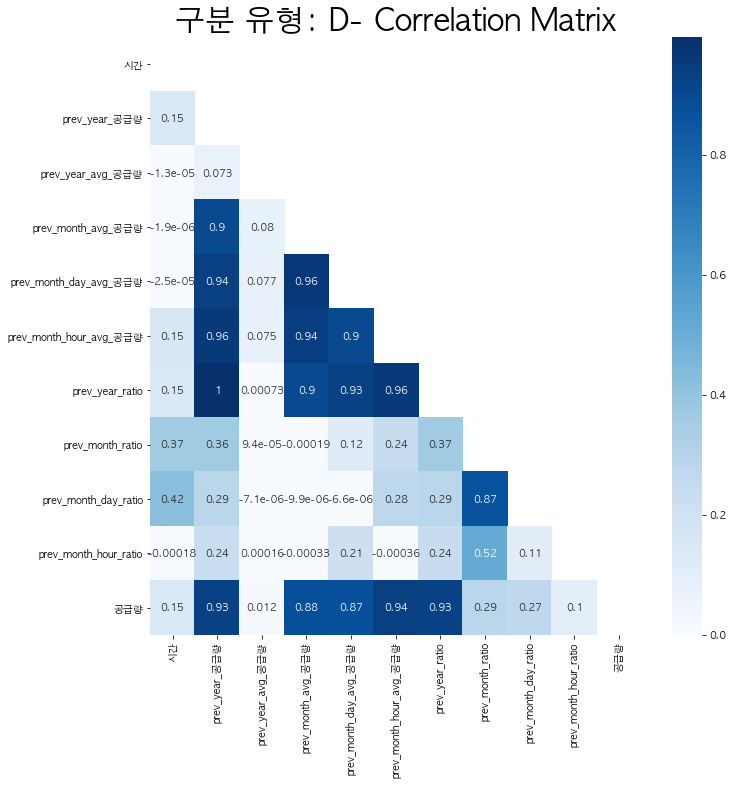

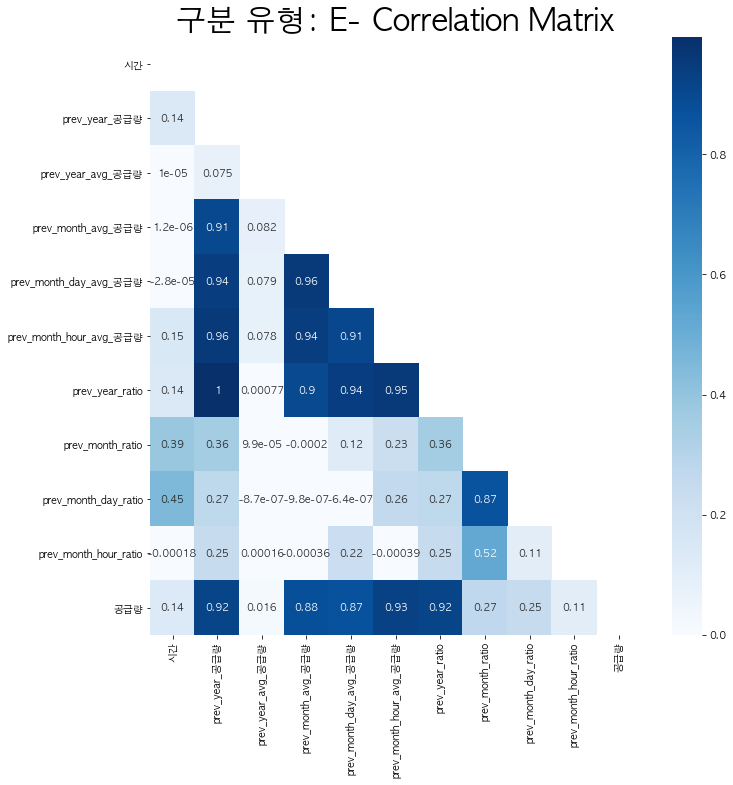

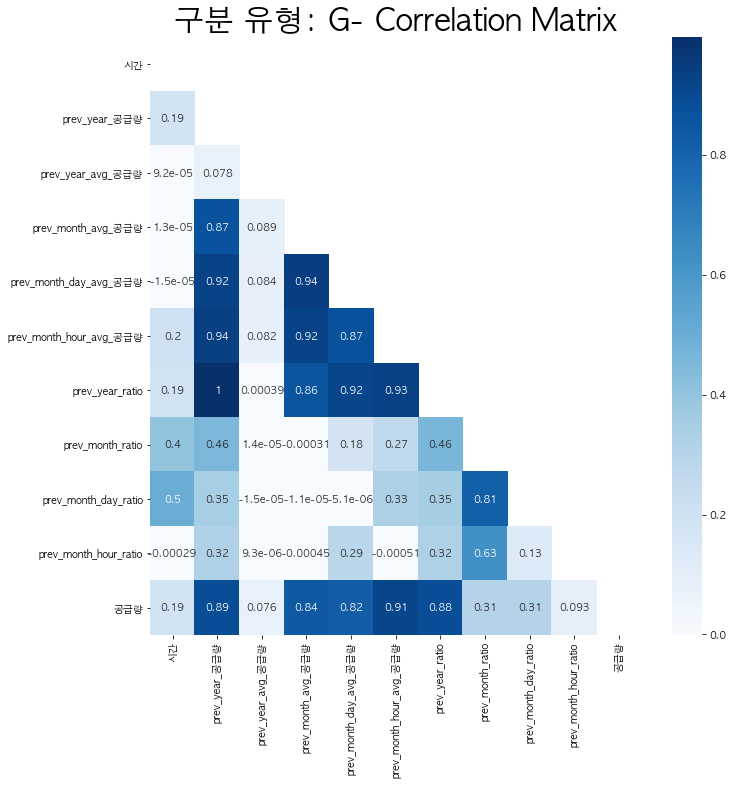

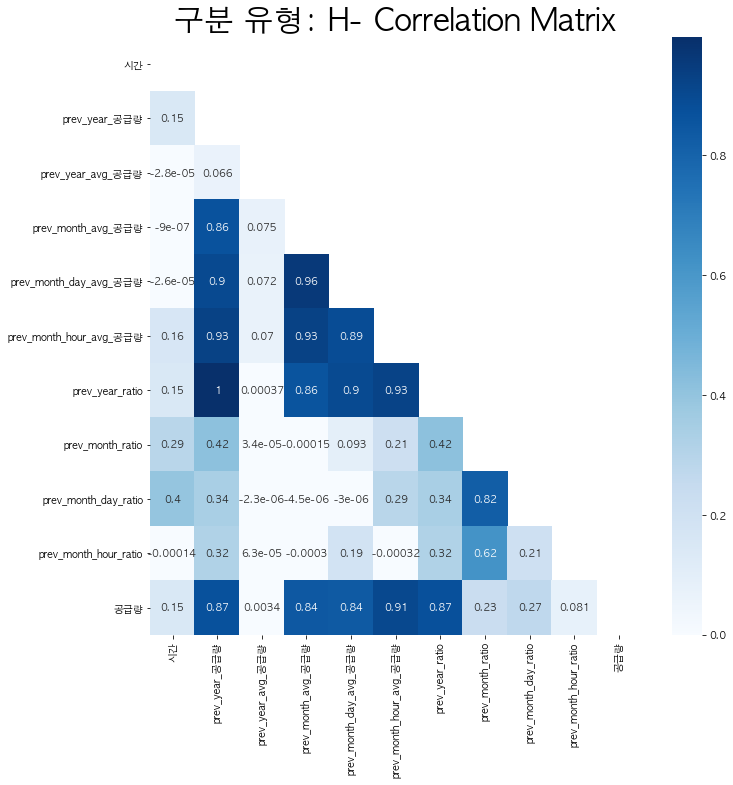

In [18]:
# 2014년~2018년까지 데이터 짜르기
cond = (final_df['연월일'].dt.year >= 2014) & (final_df['연월일'].dt.year < 2019)
dataset = final_df[cond]


import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')

gubun_cols = dataset['구분'].unique()
for gubun in gubun_cols:
    sub_df = dataset[dataset['구분'] == gubun]
    corr_df = sub_df.corr()
    mask = np.triu(corr_df)
    
    plt.figure(figsize=(11, 11))
    sns.heatmap(data=corr_df, annot=True, cmap='Blues', mask=mask)
    plt.title(f"구분 유형: {gubun}- Correlation Matrix", fontsize=30)

- Y값과의 상관관계
    - A,B,D,E,G,H 유형
        - 시간: 0.15
        - prev_year_공급량: 0.87~0.92
        - prev_year_avg_공급량: 0.000대로 **삭제하자**
        - prev_month_avg_공급량: 0.84~0.88
        - prev_month_day_avg_공급량: 0.82~0.87
        - prev_month_hour_avg_공급량: 0.91~0.93
        - prev_year_ratio: 0.87~0.93
        - prev_month_ratio : 0.23~0.31
        - prev_month_day_ratio: 0.25~0.29
        - prev_month_hour_ratio: 0.08~0.1 -> **삭제해도 괜춘할듯..?**
    - C 유형
        - 시간: 0.12
        - prev_year_공급량: 0.72
        - prev_year_avg_공급량: -0.026 **삭제하자**
        - prev_month_avg_공급량: 0.73
        - prev_month_day_avg_공급량: 0.69
        - prev_month_hour_avg_공급량: 0.77
        - prev_year_ratio: 0.74
        - prev_month_ratio : 0.12
        - prev_month_day_ratio: 0.16
        - prev_month_hour_ratio: 0.05 -> **삭제해도 괜춘할듯..?**
    - 유독 C 유형은 상관관계 값이 낮음.. -> **따라서 C 유형 별도로 모델 만들어야 함은 분명함!**
- 다중공선성 제거?

In [20]:
no_corr_cols = ['prev_year_avg_공급량', 'prev_month_hour_ratio']
df = final_df.copy()
df = df.drop(no_corr_cols, axis=1)

In [23]:
# 그냥 선형회귀로 모델링 해보자 + 스케일링 + simul=False, split=False

df = extract_dataset(final_df=df, split=False)
df = predict_simultaneously(final_df=df, simultaneously=False)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler


def predict_scaling_ftr(final_df, model, submission_csv):
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    all_pred = np.array([])
    for gubun in cols:
        sub_df = final_df[final_df['구분'] == gubun]
        sub_df = sub_df.set_index(['연월일', '시간', '구분'])
        idx_level = sub_df.index.get_level_values
        
        train = sub_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
        valid = sub_df[(idx_level(0) >= '2018-09-01')&(idx_level(0) <= '2018-12-31')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # Scaling feature
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        # fit model
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_NMAE = get_NMAE(y_train, train_pred)
        valid_NMAE = get_NMAE(y_valid, valid_pred)
        print(f'# 유형({gubun}) - Train NMAE: {train_NMAE: .4f}')
        print(f'# 유형({gubun}) - Valid NMAE: {valid_NMAE: .4f}')
        print()
        
        # 다시 Train, Test로 분할
        train = sub_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
        test = sub_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_test = train.iloc[:, :-1].values
        # Scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # fit model
        model.fit(X_train, y_train)
        # predict
        test_pred = model.predict(X_test)
        all_pred = np.append(all_pred, test_pred)
    submission_csv['공급량'] = all_pred
    return submission_csv

In [45]:
# model
lgbm_reg = LGBMRegressor(n_estimators=100, random_state=42)
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
hybrid_voting = VotingRegressor([('lgbm', lgbm_reg),('xgb', xgb_reg)])

# submission_csv
submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')

pred_csv = predict_scaling_ftr(final_df=df, model=hybrid_voting, submission_csv=submission_csv)

[13:02:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1210
# 유형(A) - Valid NMAE:  0.1580

[13:02:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1270
# 유형(B) - Valid NMAE:  0.1660

[13:02:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:03:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  1.6430
# 유형(C) - Valid NMAE:  0.2700

[13:03:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:03:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(

ValueError: Length of values (306768) does not match length of index (15120)

### Stacking(4)
- 기존 스태킹 모델이 오버피팅이 심했음..
    - 불필요한 변수 2개 삭제 ['prev_year_avg_공급량', 'prev_month_hour_ratio']
    - 모델 복잡도 낮추기
    - 수치형 변수 스케일링 추가

In [48]:
from sklearn.preprocessing import MinMaxScaler


def predict_single_model_gubun(final_df, idx_level, model, gubun, scaler):
    #=============================
    # Train, Validation 나누기
    #=============================
    train_v = final_df[(idx_level(0) < '2018-09-01')]
    valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')]
    # X, y 분할
    X_train_v, y_train_v = train_v.iloc[:, :-1].values, train_v['공급량']
    X_valid_v, y_valid_v = valid_v.iloc[:, :-1].values, valid_v['공급량']
    # Scaling feature
    X_train_v = scaler.fit_transform(X_train_v)
    X_valid_v = scaler.transform(X_valid_v)
    # fit
    model.fit(X_train_v, y_train_v)
    # predict
    train_pred_v = model.predict(X_train_v)
    valid_pred_v = model.predict(X_valid_v)
    
    #=============================
    # Train, Test로 나누어 학습 및 예측
    #=============================
    train = final_df[(idx_level(0) < '2019-01-01')]
    test = final_df[(idx_level(0) >= '2019-01-01')]
    print(f'📌 {gubun}-> # Train shape:', train.shape, '# Test shape:', test.shape)
    # X, y 분할
    X_train, y_train = train.iloc[:, :-1].values, train['공급량']
    X_test = test.iloc[:, :-1].values
    # Scaling feature
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # fit
    model.fit(X_train, y_train)
    # predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print(f'📌 {gubun} -> ### Model:', model)
    print(f'📌 {gubun} -> # Train pred shape:', train_pred.shape, '# Test pred shape:', test_pred.shape)
    print()
    return train_pred_v, valid_pred_v, train_pred, test_pred


def predict_stacking_gubun(final_df, meta_model, single_models, gubun='A'):
    # 인자로 넣어준 구분 유형 데이터프레임
    final_df = final_df[final_df['구분'] == gubun]
    # Multiindex로 변경
    final_df = final_df.set_index(['연월일', '시간', '구분'])
    idx_level = final_df.index.get_level_values
    # 메타모델 성능 체크하기 위해 y값 따로 떼놓기
    y_train_v = final_df[(idx_level(0) < '2018-09-01')]['공급량'].values
    y_valid_v = final_df[(idx_level(0) >= '2018-09-01') & (idx_level(0) <= '2018-12-31')]['공급량'].values
    # 메타모델 최종 성능 학습 및 테스트 하기 위해 y값 따로 떼놓기
    y_train = final_df[(idx_level(0) < '2019-01-01')]['공급량'].values
    y_test = final_df[(idx_level(0) >= '2019-01-01')]['공급량'].values  # 최종 예측할 값들이므로 NaN값들임!
    
    #==================================
    # 메타모델의 학습데이터로 사용될 행렬들 초기화
    #==================================
    # 메타모델 성능 검증용 초기화 행렬
    X_train_v = np.zeros((y_train_v.shape[0], len(single_models)))
    X_valid_v = np.zeros((y_valid_v.shape[0], len(single_models)))
    # 메타모델 최종 학습 및 테스트 초기화 행렬
    X_train = np.zeros((y_train.shape[0], len(single_models)))
    X_test = np.zeros((y_test.shape[0], len(single_models)))
    
    #=======================
    # single model 하나씩 수행
    #=======================
    for i, single_model in enumerate(single_models):
        scaler = MinMaxScaler()
        train_pred_v, valid_pred_v, train_pred, test_pred = predict_single_model_gubun(final_df, idx_level, 
                                                                                       single_model, gubun,
                                                                                      scaler)
        # numpy array concatenate
        X_train_v[:, i] = train_pred_v
        X_valid_v[:, i] = valid_pred_v
        X_train[:, i] = train_pred
        X_test[:, i] = test_pred
    
    #==============================
    # 메타모델로 최종 성능 검증 및 최종 예측
    #==============================
    # 성능 검증
    meta_model.fit(X_train_v, y_train_v)
    TRAIN_V_PRED = meta_model.predict(X_train_v)
    VALID_V_PRED = meta_model.predict(X_valid_v)
    TRAIN_V_NMAE = get_NMAE(y_train_v, TRAIN_V_PRED)
    VALID_V_NMAE = get_NMAE(y_valid_v, VALID_V_PRED)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Train NMAE:', TRAIN_V_NMAE)
    print(f'📌 {gubun} -> 🔥최종 메타 모델 성능 검증- Valid NMAE:', VALID_V_NMAE)
    
    # 최종 예측 
    meta_model.fit(X_train, y_train)
    FINAL_TEST_PRED = meta_model.predict(X_test)
     
#     print('메타모델에 사용될 데이터들')
#     print('X_train_v:', X_train_v.shape, 'X_valid_v:', X_valid_v.shape)
#     print('y_train_v:', y_train_v.shape, 'y_valid_v:', y_valid_v.shape)
#     print()
#     print('X_train:', X_train.shape, 'X_test:', X_test.shape)
#     print('y_train:', y_train.shape, 'y_test:', y_test.shape)
    print('TEST_LABEL shape:', y_test.shape, 'TEST_PRED shape:', FINAL_TEST_PRED.shape)
    return FINAL_TEST_PRED


def predict_stacking(final_df, submission_csv, meta_model, single_models: list, gubuns: list):
    total_gubun_pred = np.array([])
    # 각 구분 유형 별로 Stacking 모델로 예측
    for gubun in gubuns:
        gubun_test_pred = predict_stacking_gubun(final_df, meta_model, single_models, gubun)
        total_gubun_pred = np.append(total_gubun_pred, gubun_test_pred)
    
    # 제출 파일에 칼럼으로 넣기
    submission_csv['공급량'] = total_gubun_pred
    
    return submission_csv

In [51]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# model
single_lgbm = LGBMRegressor(n_estimators=100, random_state=42)
single_xgb = XGBRFRegressor(n_estimators=100, random_state=42)
single_models = [single_lgbm, single_xgb]
meta_model = LinearRegression()

# submission_csv
submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')

# 구분 unique 값들
gubuns = df['구분'].unique()

pred_csv = predict_stacking(final_df=df, submission_csv=submission_csv,
                           meta_model=meta_model, single_models=single_models, gubuns=gubuns)

📌 A-> # Train shape: (43824, 8) # Test shape: (2160, 8)
📌 A -> ### Model: LGBMRegressor(random_state=42)
📌 A -> # Train pred shape: (43824,) # Test pred shape: (2160,)

[13:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
📌 A-> # Train shape: (43824, 8) # Test shape: (2160, 8)
[13:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
📌 A -> ### Model: XGBRFRegressor(random_state=42)
📌 A -> # Train pred shape: (43824,) # Test pred shape: (2160,)

📌 A -> 🔥최종 메타 모델 성능 검증- Train NMAE: 0.106
📌 A -> 🔥최종 메타 모델 성능 검증- Valid NMAE: 0.158
TEST_LABEL shape: (2160,) TEST_PRED shape: (2160,)
📌 B-> # Train shape: (43824, 8) # Test shape: (2160, 8)
📌 B -> ### Model: LGBMRegressor(random_state=42)
📌 B -> # Train pred shape: (43824,) # Test pred shape: (2160,)

[13:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
📌 B-> # T

In [59]:
# C 유형에 대해서 Prophet으로 예측해보기
c_df = df[df['구분'] == 'C']

def date_format_pandas(row):
    if row['시간'] == 24:
        row['연월일'] += pd.DateOffset(days=1)
        row['시간'] = 0
    return row

c_df = c_df.apply(date_format_pandas, axis=1)
c_df['시간'] = c_df['시간'].apply(lambda x: str(x) if x >= 10 else '0'+str(x))
c_df['연월일'] = c_df['연월일'].astype(str)
c_df['time'] = c_df['연월일'] + ' ' + c_df['시간']
c_df['time'] = pd.to_datetime(c_df['time'], format='%Y-%m-%d %H')

In [61]:
# 일변량으로 Kats Prophet 사용
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

# Train, Valid 분할
c_train = c_df[c_df['연월일'] < '2018-09-01']
c_valid = c_df[(c_df['연월일'] >= '2018-09-01')&(c_df['연월일'] <= '2018-12-31')]

uni_c_df = c_train[['time', '공급량']]
uni_c_ts = TimeSeriesData(uni_c_df)

# params
params = ProphetParams(seasonality_mode='additive')
# model
prophet = ProphetModel(uni_c_ts, params=params)
# fit
prophet.fit()
# predict
valid_pred = prophet.predict(steps=c_valid.shape[0], freq='H')

In [66]:
# 일변량일때 -> VALID NMAE
get_NMAE(c_valid['공급량'].values, valid_pred['fcst'].values)

0.174

In [84]:
# 일변량으로 Kats Prophet 사용
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

# Train, Valid 분할
c_train = c_df[c_df['time'] <= '2019-01-01 00:00:00']
c_test = c_df[(c_df['time'] > '2019-01-01 00:00:00')]

uni_c_df = c_train[['time', '공급량']]
uni_c_ts = TimeSeriesData(uni_c_df)

# params
params = ProphetParams(seasonality_mode='additive')
# model
prophet = ProphetModel(uni_c_ts, params=params)
# fit
prophet.fit()
# predict
test_pred = prophet.predict(steps=c_test.shape[0], freq='H')

In [85]:
pred_csv['일자'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[0]
pred_csv['시간'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[1]
pred_csv['구분'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[2]
pred_csv['일자'] = pd.to_datetime(pred_csv['일자'])
pred_csv['시간'] = pred_csv['시간'].astype(int)

In [91]:
final_csv = pred_csv[pred_csv['구분'] != 'C']
c_csv = pred_csv[pred_csv['구분'] == 'C']
c_csv['공급량'] = test_pred['fcst'].values

In [92]:
final_csv = pd.concat([final_csv, c_csv], axis=0)
final_csv = final_csv.sort_values(by=['구분', '일자', '시간'])

In [98]:
import os

save_dir = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/submission'
filename = '0103False_SimulFalse_Stacking(lgbm+xgb_meta:lr_reg)_cols-autocorr(exclude_vars)_C_separated_Prophet.csv'

final_csv[['일자|시간|구분','공급량']].to_csv(os.path.join(save_dir, filename), index=False)

---

### 자기상관 변수 더 만들기

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler


def predict_scaling_ftr(final_df, model, submission_csv):
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    all_pred = np.array([])
    for gubun in cols:
        sub_df = final_df[final_df['구분'] == gubun]
        sub_df = sub_df.set_index(['연월일', '시간', '구분'])
        idx_level = sub_df.index.get_level_values
        
        train = sub_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
        valid = sub_df[(idx_level(0) >= '2018-09-01')&(idx_level(0) <= '2018-12-31')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # Scaling feature
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        # fit model
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_NMAE = get_NMAE(y_train, train_pred)
        valid_NMAE = get_NMAE(y_valid, valid_pred)
        print(f'# 유형({gubun}) - Train NMAE: {train_NMAE: .4f}')
        print(f'# 유형({gubun}) - Valid NMAE: {valid_NMAE: .4f}')
        print()
        
        # 다시 Train, Test로 분할
        train = sub_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
        test = sub_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_test = test.iloc[:, :-1].values
        # Scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # fit model
        model.fit(X_train, y_train)
        # predict
        test_pred = model.predict(X_test)
        all_pred = np.append(all_pred, test_pred)
    submission_csv['공급량'] = all_pred
    return submission_csv

xgb = XGBRegressor(n_estimators=100, random_state=42)
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
hybrid = VotingRegressor([('xgb', xgb), ('lgbm', lgbm)])

submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')

# Predict
pred_csv = predict_scaling_ftr(final_df=df, model=hybrid, submission_csv=submission_csv)

[14:09:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1210
# 유형(A) - Valid NMAE:  0.1580

[14:09:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1270
# 유형(B) - Valid NMAE:  0.1660

[14:09:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  1.6430
# 유형(C) - Valid NMAE:  0.2700

[14:09:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(

In [105]:
pred_csv.to_csv('0103False_SimulFalse_xgb+lgbm_cols-autocorr(exlcude_vars)_MinMaxScaling.csv', index=False)

In [117]:
# 1.prev_month_avg 대비 prev_month_day_avg 공급량 ratio
df['prev_month&month-day_ratio'] = (df['prev_month_day_avg_공급량'] - df['prev_month_avg_공급량']) / df['prev_month_avg_공급량']
# 2.prev_month_avg 대비 prev_month_hour_avg 공급량 ratio
df['prev_month&month-hour_ratio'] = (df['prev_month_hour_avg_공급량'] - df['prev_month_avg_공급량']) / df['prev_month_avg_공급량']



In [118]:
cols_order = df.columns.tolist()
cols_order.remove('공급량')
cols_order.insert(len(cols_order), '공급량')

fe_df = df[cols_order]

In [119]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
hybrid = VotingRegressor([('xgb', xgb), ('lgbm', lgbm)])

submission_csv = pd.read_csv('/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas/sample_submission.csv')

# Predict
pred_csv = predict_scaling_ftr(final_df=fe_df, model=hybrid, submission_csv=submission_csv)

[14:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1180
# 유형(A) - Valid NMAE:  0.1580

[14:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1240
# 유형(B) - Valid NMAE:  0.1690

[14:25:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  1.5660
# 유형(C) - Valid NMAE:  0.2730

[14:25:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(

### 하이퍼파라미터 튜닝

In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler


def grid_search(final_df, model):
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    TRAIN_NMAE = []
    VALID_NMAE = []
    all_pred = np.array([])
    for gubun in cols:
        sub_df = final_df[final_df['구분'] == gubun]
        sub_df = sub_df.set_index(['연월일', '시간', '구분'])
        idx_level = sub_df.index.get_level_values
        
        train = sub_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
        valid = sub_df[(idx_level(0) >= '2018-09-01')&(idx_level(0) <= '2018-12-31')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # Scaling feature
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        # fit model
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_NMAE = get_NMAE(y_train, train_pred)
        valid_NMAE = get_NMAE(y_valid, valid_pred)
#         print(f"# 모델 유형: {model}")
#         print(f'# 유형({gubun}) - Train NMAE: {train_NMAE: .4f}')
#         print(f'# 유형({gubun}) - Valid NMAE: {valid_NMAE: .4f}')
#         print()
        TRAIN_NMAE.append(train_NMAE)
        VALID_NMAE.append(valid_NMAE)
    return cols, TRAIN_NMAE, VALID_NMAE
        

In [164]:
from itertools import product
from tqdm import tqdm

boosting_type = ['gbdt', 'dart', 'goss']
learning_rate = [0.1, 0.001, 0.0001]
n_estimators = [100, 400]
min_child_samples = [5, 20, 50]
params = [boosting_type, learning_rate, n_estimators, min_child_samples]

metric_df = pd.DataFrame()
flag = 0
for comb in tqdm(list(product(*params))):
    flag += 1
    lgbm = LGBMRegressor(boosting_type=comb[0], learning_rate=comb[1],
                         n_estimators=comb[2], min_child_samples=comb[3], random_state=42)
    gubuns, TRAIN_NMAE, VALID_NMAE = grid_search(final_df=fe_df, model=lgbm)
    # 멀티인덱스 설정
    multi_idx = pd.MultiIndex.from_tuples(tuple(((comb, g) for g in gubuns)))
    eval_df = pd.DataFrame(index=multi_idx)
    eval_df['Train NMAE'] = TRAIN_NMAE
    eval_df['Valid NMAE'] = VALID_NMAE
    metric_df = pd.concat([metric_df, eval_df], axis=0)

100%|██████████| 54/54 [23:54<00:00, 26.57s/it]


In [169]:

test_df = metric_df.reset_index()

In [174]:
gubuns = ['A', 'B', 'C', 'D', 'E', 'G', 'H']

for gubun in gubuns:
    sub_df = test_df[test_df['level_1'] == gubun]
    sub_df = sub_df.sort_values(by=['Valid NMAE', 'Train NMAE'])
    display(sub_df.head(15))

,level_0,level_1,Train NMAE,Valid NMAE
259,"(goss, 0.1, 100, 20)",A,0.105,0.156
252,"(goss, 0.1, 100, 5)",A,0.104,0.157
7,"(gbdt, 0.1, 100, 20)",A,0.105,0.158
266,"(goss, 0.1, 100, 50)",A,0.108,0.158
0,"(gbdt, 0.1, 100, 5)",A,0.106,0.159
28,"(gbdt, 0.1, 400, 20)",A,0.073,0.160
280,"(goss, 0.1, 400, 20)",A,0.079,0.160
287,"(goss, 0.1, 400, 50)",A,0.085,0.160
14,"(gbdt, 0.1, 100, 50)",A,0.106,0.161
273,"(goss, 0.1, 400, 5)",A,0.075,0.162


,level_0,level_1,Train NMAE,Valid NMAE
281,"(goss, 0.1, 400, 20)",B,0.085,0.163
260,"(goss, 0.1, 100, 20)",B,0.111,0.164
253,"(goss, 0.1, 100, 5)",B,0.110,0.165
22,"(gbdt, 0.1, 400, 5)",B,0.080,0.166
274,"(goss, 0.1, 400, 5)",B,0.082,0.166
1,"(gbdt, 0.1, 100, 5)",B,0.111,0.166
15,"(gbdt, 0.1, 100, 50)",B,0.111,0.166
29,"(gbdt, 0.1, 400, 20)",B,0.079,0.167
36,"(gbdt, 0.1, 400, 50)",B,0.084,0.167
8,"(gbdt, 0.1, 100, 20)",B,0.110,0.167


,level_0,level_1,Train NMAE,Valid NMAE
135,"(dart, 0.1, 100, 20)",C,1.519,0.216
128,"(dart, 0.1, 100, 5)",C,1.557,0.218
142,"(dart, 0.1, 100, 50)",C,1.604,0.220
156,"(dart, 0.1, 400, 20)",C,1.070,0.244
149,"(dart, 0.1, 400, 5)",C,1.053,0.246
163,"(dart, 0.1, 400, 50)",C,1.269,0.246
254,"(goss, 0.1, 100, 5)",C,1.020,0.271
275,"(goss, 0.1, 400, 5)",C,0.565,0.273
289,"(goss, 0.1, 400, 50)",C,0.879,0.276
268,"(goss, 0.1, 100, 50)",C,1.294,0.276


,level_0,level_1,Train NMAE,Valid NMAE
17,"(gbdt, 0.1, 100, 50)",D,0.107,0.160
10,"(gbdt, 0.1, 100, 20)",D,0.106,0.161
269,"(goss, 0.1, 100, 50)",D,0.108,0.161
283,"(goss, 0.1, 400, 20)",D,0.081,0.162
3,"(gbdt, 0.1, 100, 5)",D,0.106,0.162
31,"(gbdt, 0.1, 400, 20)",D,0.075,0.163
290,"(goss, 0.1, 400, 50)",D,0.086,0.163
255,"(goss, 0.1, 100, 5)",D,0.105,0.163
24,"(gbdt, 0.1, 400, 5)",D,0.076,0.165
276,"(goss, 0.1, 400, 5)",D,0.078,0.165


,level_0,level_1,Train NMAE,Valid NMAE
151,"(dart, 0.1, 400, 5)",E,0.101,0.162
158,"(dart, 0.1, 400, 20)",E,0.100,0.164
165,"(dart, 0.1, 400, 50)",E,0.101,0.164
11,"(gbdt, 0.1, 100, 20)",E,0.094,0.165
4,"(gbdt, 0.1, 100, 5)",E,0.094,0.166
263,"(goss, 0.1, 100, 20)",E,0.093,0.167
18,"(gbdt, 0.1, 100, 50)",E,0.095,0.168
256,"(goss, 0.1, 100, 5)",E,0.094,0.170
270,"(goss, 0.1, 100, 50)",E,0.095,0.171
144,"(dart, 0.1, 100, 50)",E,0.124,0.171


,level_0,level_1,Train NMAE,Valid NMAE
257,"(goss, 0.1, 100, 5)",G,0.100,0.161
264,"(goss, 0.1, 100, 20)",G,0.102,0.161
5,"(gbdt, 0.1, 100, 5)",G,0.103,0.161
12,"(gbdt, 0.1, 100, 20)",G,0.102,0.162
271,"(goss, 0.1, 100, 50)",G,0.104,0.162
19,"(gbdt, 0.1, 100, 50)",G,0.102,0.164
166,"(dart, 0.1, 400, 50)",G,0.112,0.164
159,"(dart, 0.1, 400, 20)",G,0.111,0.166
152,"(dart, 0.1, 400, 5)",G,0.112,0.166
145,"(dart, 0.1, 100, 50)",G,0.133,0.167


,level_0,level_1,Train NMAE,Valid NMAE
6,"(gbdt, 0.1, 100, 5)",H,0.110,0.159
13,"(gbdt, 0.1, 100, 20)",H,0.110,0.159
153,"(dart, 0.1, 400, 5)",H,0.116,0.160
160,"(dart, 0.1, 400, 20)",H,0.116,0.160
258,"(goss, 0.1, 100, 5)",H,0.110,0.161
20,"(gbdt, 0.1, 100, 50)",H,0.111,0.162
265,"(goss, 0.1, 100, 20)",H,0.111,0.162
272,"(goss, 0.1, 100, 50)",H,0.111,0.162
167,"(dart, 0.1, 400, 50)",H,0.117,0.163
27,"(gbdt, 0.1, 400, 5)",H,0.084,0.165


- 유형 별로 가장 좋은 하이퍼파라미터 별로 예측한 후 제출해보기